# ver 2

In [ ]:
!pip install hmmlearn scikit-learn cvxpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 12.7 MB/s eta 0:00:00


[*********************100%***********************]  4 of 4 completed


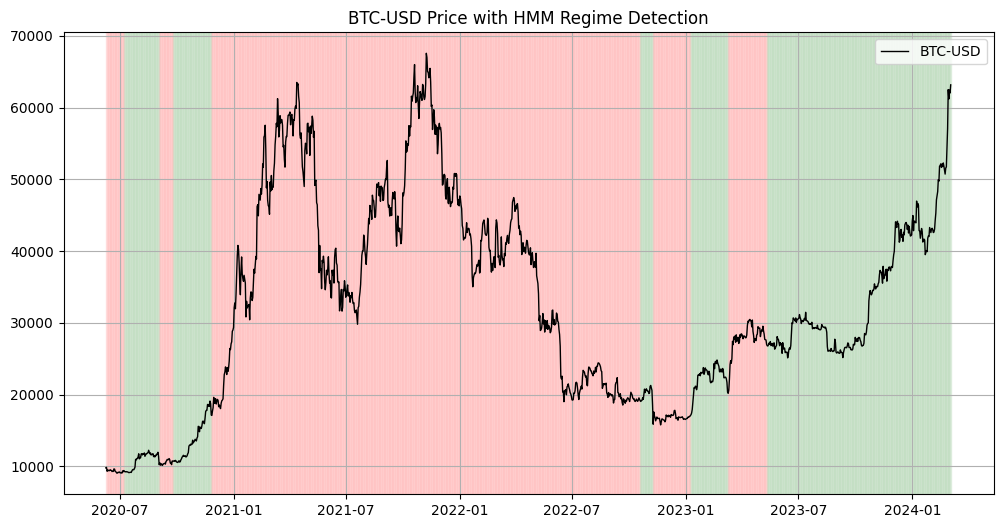

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import cvxpy as cp
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler

# 1. Settings & helper funcs
TICKERS = ["BTC-USD", "ETH-USD", "BNB-USD", "SOL-USD"]
START = "2020-01-01"
VOL_WINDOW = 60
HMM_STATES = 2
LOOKBACK_DAYS = 90
REBALANCE_FREQ = 'ME'
GAMMA_BY_REGIME = {"low_vol": 5.0, "high_vol": 1.0, "neutral": 3.0}
MAX_WEIGHT = 0.6
RISK_FREE = 0.0
TX_COST = 0.001  # 0.1%

np.random.seed(42)

def download_prices(tickers, start=START):
    df = yf.download(tickers, start=start, auto_adjust=True)["Close"]
    df = df.ffill().dropna(how='all')
    if isinstance(df, pd.Series): df = df.to_frame()
    return df

def log_returns(prices):
    return np.log(prices / prices.shift(1)).dropna()

def summarize_perf(returns):
    ann_ret = (1 + returns).prod()**(252/len(returns)) - 1
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = (ann_ret - RISK_FREE) / ann_vol if ann_vol > 0 else np.nan
    downside = returns[returns < 0].std() * np.sqrt(252)
    sortino = (ann_ret - RISK_FREE) / downside if downside > 0 else np.nan
    cum = (1 + returns).cumprod()
    dd = cum / cum.cummax() - 1
    mdd = dd.min()
    return {"CAGR": ann_ret, "Vol": ann_vol, "Sharpe": sharpe, "Sortino": sortino, "MaxDD": mdd}

# 2. Regime detection (HMM)
def build_hmm_regimes(returns, base_asset="BTC-USD", vol_window=VOL_WINDOW, n_states=HMM_STATES):
    r = returns[base_asset]
    ann_vol = r.rolling(vol_window).std() * np.sqrt(252)
    features = pd.concat([r, ann_vol], axis=1).dropna()
    features.columns = ["ret", "ann_vol"]
    X = features.values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=200, random_state=42)
    model.fit(Xs)
    states = model.predict(Xs)
    features["state"] = states
    vol_by_state = features.groupby("state")["ann_vol"].mean().sort_values()
    state_to_label = {}
    if len(vol_by_state) == 2:
        low, high = vol_by_state.index
        state_to_label[low] = "low_vol"
        state_to_label[high] = "high_vol"
    else:
        sorted_states = vol_by_state.index.tolist()
        state_to_label[sorted_states[0]] = "low_vol"
        state_to_label[sorted_states[-1]] = "high_vol"
        for s in sorted_states[1:-1]:
            state_to_label[s] = "neutral"
    features["regime"] = features["state"].map(state_to_label)
    return features, model, scaler

# 3. Markowitz optimizer
def markowitz_opt(mu, Sigma, gamma=1.0, w_max=MAX_WEIGHT, allow_short=False):
    n = len(mu)
    w = cp.Variable(n)
    obj = cp.quad_form(w, Sigma) - gamma * (mu @ w)
    constraints = [cp.sum(w) == 1]
    if not allow_short: constraints += [w >= 0]
    constraints += [w <= w_max]
    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve(solver=cp.OSQP, verbose=False)
    if w.value is None:
        return np.ones(n) / n
    w_opt = np.maximum(w.value, 0)
    w_opt /= w_opt.sum()
    return w_opt


# 4. Backtest
def backtest_regime_markowitz(prices, returns, regimes_df, lookback_days=LOOKBACK_DAYS,
                              rebalance_freq=REBALANCE_FREQ, gamma_map=GAMMA_BY_REGIME):
    all_dates = returns.index
    rebal_dates = all_dates.to_series().resample(rebalance_freq).last().dropna().index
    weights_history, portfolio_returns, turnovers = {}, [], []
    prev_weights = None

    for reb_date in rebal_dates:
        if reb_date not in regimes_df.index:
            valid_dates = regimes_df.index[regimes_df.index <= reb_date]
            if len(valid_dates) == 0: continue
            reb_date_use = valid_dates[-1]
        else:
            reb_date_use = reb_date

        hist = returns.loc[returns.index <= reb_date_use].tail(lookback_days)
        if len(hist) < max(30, int(lookback_days/2)): continue
        hist_simple = np.expm1(hist)
        mu, Sigma = hist_simple.mean().values, hist_simple.cov().values
        regime_label = regimes_df.loc[reb_date_use, "regime"]
        gamma = gamma_map.get(regime_label, 3.0)
        w = markowitz_opt(mu, Sigma, gamma=gamma)
        weights_history[reb_date_use] = {"weights": w, "regime": regime_label}

        # Determine next period
        next_idx = np.searchsorted(rebal_dates, reb_date)
        next_reb = rebal_dates[next_idx + 1] if next_idx + 1 < len(rebal_dates) else returns.index[-1]
        window = returns.loc[(returns.index > reb_date_use) & (returns.index <= next_reb)]
        if window.empty: continue
        window_simple = np.expm1(window)
        port_ret_window = window_simple.values.dot(w)

        # Apply transaction cost
        if prev_weights is None:
            tc = TX_COST * np.sum(np.abs(w))
        else:
            tc = TX_COST * np.sum(np.abs(w - prev_weights))
        port_ret_window -= tc / len(port_ret_window)
        portfolio_returns.append(pd.Series(port_ret_window, index=window.index))
        turnovers.append(np.sum(np.abs(w - prev_weights)) if prev_weights is not None else np.sum(np.abs(w)))
        prev_weights = w

    port_ret_series = pd.concat(portfolio_returns).sort_index()
    port_ret_series = port_ret_series[~port_ret_series.index.duplicated(keep='first')]
    equity = (1 + port_ret_series).cumprod()
    ew_ret = np.expm1(returns.loc[port_ret_series.index]).mean(axis=1)
    ew_equity = (1 + ew_ret).cumprod()
    btc_rets = np.expm1(returns["BTC-USD"].loc[port_ret_series.index])
    btc_equity = (1 + btc_rets).cumprod()

    return port_ret_series, equity, ew_ret, ew_equity, btc_rets, btc_equity, weights_history, np.mean(turnovers)


# 5. IS/OOS Split
prices = download_prices(TICKERS, start=START)
returns = log_returns(prices)
split = int(len(returns) * 0.7)
returns_is, returns_oos = returns.iloc[:split], returns.iloc[split:]

features_is, model, scaler = build_hmm_regimes(returns_is)

# Tạo features_oos có cùng index với returns_oos, gán regime = last IS regime
last_regime = features_is["regime"].iloc[-1]
features_oos = pd.DataFrame(index=returns_oos.index)
features_oos["regime"] = last_regime

# Đảm bảo prices cũng reindex đúng vùng OOS khi gọi backtest
prices_oos = prices.loc[returns_oos.index]

result = backtest_regime_markowitz(prices_oos, returns_oos, features_oos)


port_ret, equity, ew_ret, ew_eq, btc_ret, btc_eq, weights_hist, avg_turn = result

plt.figure(figsize=(12,6))
plt.plot(prices["BTC-USD"].loc[features_is.index], label="BTC-USD", color='black', lw=1)

for dt, reg in features_is["regime"].items():
    if reg == "low_vol":
        plt.axvspan(dt, dt + pd.Timedelta(days=1), color='green', alpha=0.05)
    elif reg == "high_vol":
        plt.axvspan(dt, dt + pd.Timedelta(days=1), color='red', alpha=0.05)
    else:
        plt.axvspan(dt, dt + pd.Timedelta(days=1), color='yellow', alpha=0.05)

plt.title("BTC-USD Price with HMM Regime Detection")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# --- In-Sample backtest ---
port_is, eq_is, ew_is, ew_eq_is, btc_is, btc_eq_is, _, turn_is = backtest_regime_markowitz(
    prices.loc[returns_is.index], returns_is, features_is
)

# --- Out-of-Sample backtest ---
port_oos, eq_oos, ew_oos, ew_eq_oos, btc_oos, btc_eq_oos, _, turn_oos = backtest_regime_markowitz(
    prices.loc[returns_oos.index], returns_oos, features_oos
)


In [ ]:
perf_is = summarize_perf(port_is)
perf_oos = summarize_perf(port_oos)
perf_is_btc = summarize_perf(btc_is)
perf_oos_btc = summarize_perf(btc_oos)

report = pd.DataFrame({
    "Metric": ["CAGR", "Vol", "Sharpe", "Sortino", "MaxDD"],
    "IS_Portfolio": [perf_is[m] for m in ["CAGR", "Vol", "Sharpe", "Sortino", "MaxDD"]],
    "OOS_Portfolio": [perf_oos[m] for m in ["CAGR", "Vol", "Sharpe", "Sortino", "MaxDD"]],
    "IS_BTC": [perf_is_btc[m] for m in ["CAGR", "Vol", "Sharpe", "Sortino", "MaxDD"]],
    "OOS_BTC": [perf_oos_btc[m] for m in ["CAGR", "Vol", "Sharpe", "Sortino", "MaxDD"]],
})
print(report.round(4))


    Metric  IS_Portfolio  OOS_Portfolio  IS_BTC  OOS_BTC
0     CAGR        1.0774         0.1876  0.4377   0.2836
1      Vol        0.7213         0.4711  0.5201   0.3828
2   Sharpe        1.4937         0.3982  0.8416   0.7409
3  Sortino        2.0997         0.5871  1.1772   1.1952
4    MaxDD       -0.7656        -0.4056 -0.7663  -0.2814


PERFORMANCE REPORT (OOS)
Portfolio: CAGR       0.1876
Vol        0.4711
Sharpe     0.3982
Sortino    0.5871
MaxDD     -0.4056
dtype: float64
Equal-Weight: CAGR       0.2239
Vol        0.4743
Sharpe     0.4721
Sortino    0.6946
MaxDD     -0.4358
dtype: float64
BTC Benchmark: CAGR       0.2836
Vol        0.3828
Sharpe     0.7409
Sortino    1.1952
MaxDD     -0.2814
dtype: float64

Average Turnover: 0.8121
Monte Carlo VaR95=-0.0009, VaR99=-0.0017


Text(0.5, 1.0, 'Equity Curves with Regime Signal')

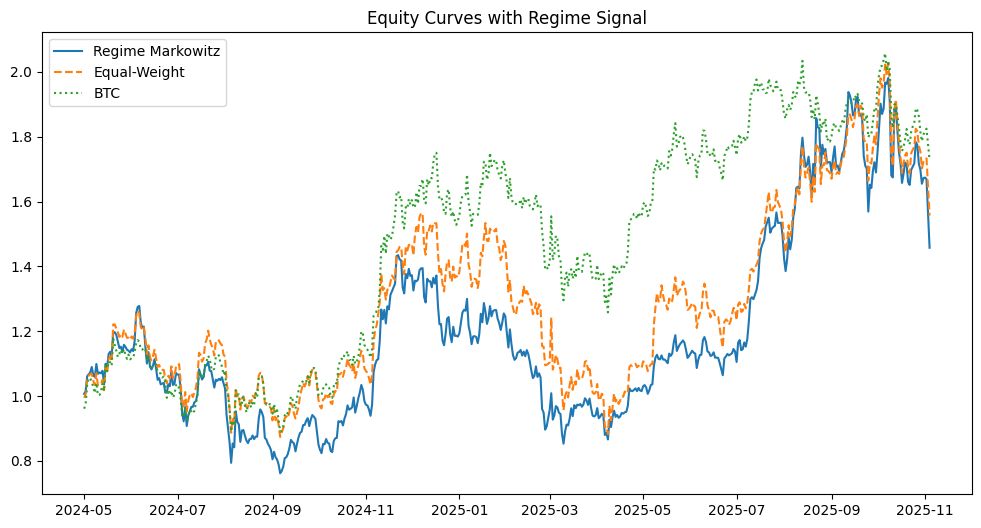

In [ ]:
# 6. Stress Test (Monte Carlo)
sim_rets = []
for _ in range(1000):
    sim = np.random.choice(port_ret, size=len(port_ret), replace=True)
    sim_rets.append(sim)
sim_df = pd.DataFrame(sim_rets)
VaR_95 = np.percentile(sim_df.mean(axis=1), 5)
VaR_99 = np.percentile(sim_df.mean(axis=1), 1)

# 7. Performance Report
perf_port = summarize_perf(port_ret)
perf_ew = summarize_perf(ew_ret)
perf_btc = summarize_perf(btc_ret)

print("PERFORMANCE REPORT (OOS)")
print("Portfolio:", pd.Series(perf_port).round(4))
print("Equal-Weight:", pd.Series(perf_ew).round(4))
print("BTC Benchmark:", pd.Series(perf_btc).round(4))
print(f"\nAverage Turnover: {avg_turn:.4f}")
print(f"Monte Carlo VaR95={VaR_95:.4f}, VaR99={VaR_99:.4f}")


# 8. Visualization
plt.figure(figsize=(12,6))
plt.plot(equity, label="Regime Markowitz")
plt.plot(ew_eq, label="Equal-Weight", linestyle='--')
plt.plot(btc_eq, label="BTC", linestyle=':')
plt.legend()
plt.title("Equity Curves with Regime Signal")